# Procesado de valores no disponibles en *dataset* life_expectancy

## Exploración de datos

In [23]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/life_expectancy.csv')

df.shape

(2938, 22)

Por simplicidad, se hará parte del preprocesado antes de separar los conjuntos de entrenamiento y test.

Comprobamos que hay valores nulos en el dataset. Veamos en qué columnas hay más.

In [24]:
na_per_colum = df.isna().sum()
na_per_colum[na_per_colum > 0].sort_values(ascending=False)

Population           652
HepatitisB           553
GDP                  448
Total expenditure    226
Alcohol              194
Income               167
Schooling            163
thinness5-9           34
thinness1-19          34
BMI                   34
Polio                 19
Diphtheria            19
LifeExpectancy        10
AdultMortality        10
dtype: int64

Ordenamos las *features* por su nivel de correlación (cuáles son más predictivas)

In [25]:
df.corr(numeric_only=True)['LifeExpectancy'].sort_values(ascending=False, key=np.abs)

LifeExpectancy        1.000000
Schooling             0.751975
Income                0.724776
AdultMortality       -0.696359
BMI                   0.567694
HIV/AIDS             -0.556556
Diphtheria            0.479495
thinness1-19         -0.477183
thinness5-9          -0.471584
Polio                 0.465556
GDP                   0.461455
Alcohol               0.404877
percentExpenditure    0.381864
HepatitisB            0.256762
underfiveDeaths      -0.222529
Total expenditure     0.218086
InfantDeaths         -0.196557
Year                  0.170033
Measles              -0.157586
Population           -0.021538
Name: LifeExpectancy, dtype: float64

Y comprobamos qué columnas categoricas hay en el dataset.

In [26]:
df.select_dtypes(exclude=[np.number]).columns

Index(['Country', 'Status'], dtype='object')

In [27]:
df['Status'].value_counts()

Status
Developing    2426
Developed      512
Name: count, dtype: int64

In [28]:
df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})
df.corr(numeric_only=True)['Status'].sort_values(ascending=False, key=np.abs) # Datos interesantes

Status                1.000000
Alcohol               0.596660
Schooling             0.514045
LifeExpectancy        0.482136
Income                0.478402
GDP                   0.478339
percentExpenditure    0.454261
thinness1-19         -0.368389
thinness5-9          -0.366751
AdultMortality       -0.315284
BMI                   0.311257
Total expenditure     0.299990
Polio                 0.220250
Diphtheria            0.216913
HIV/AIDS             -0.148590
HepatitisB            0.115317
underfiveDeaths      -0.115195
InfantDeaths         -0.112252
Measles              -0.076955
Population           -0.045801
Year                 -0.001864
Name: Status, dtype: float64

## Tratamiento de valores no disponibles

Dado que nuestra variable objetivo tiene valores no disponibles. Eliminamos esas filas, ya que solo vamos a considerar algoritmos de aprendizaje supervisado. Como se podría intuir por ser el mismo número total, son las mismas filas en las que faltaba 'AdultMortality', así que también esos nulos quedan eliminados. 

La columna 'Population' es la que más valores no disponibles tiene y la que guarda menos correlación con la variable objetivo. Por lo que la eliminamos también. 'HepatitisB' y 'GDP' también tienen bastantes valores no disponibles, pero tienen algo más de correlación y la decisión puede ser más difícil de tomar. Eliminaremos "HepatitisB" y dejaremos "GDP" para ver cómo se comporta en los distintos métodos de tratamiento de valores faltantes ya que sí parece una variable relevante.

Decido eliminar las columnas categóricas:
- 'Country' tendría que procesarse con OneHotEncoding, pero al haber 193 países, el número de columnas resultante sería muy grande.
- 'Status' es una variable con solo dos opciones que previsiblemente correlará con elmentos como el GDP, por lo que no aportará información adicional.

La columna 'Year' tampoco debería aportar información adicional (especialmente una vez desacartado el país), y además vemos que, en efecto, su correlación es baja.

En realidad, dado que vamos a utilizar modelos predictivos de imputación (se pide explícitamente), sería razonable no eliminar algunas de estas columnas hasta después de la imputación para que ésta se haga con la mayor información posible, pero por simplicidad las eliminaremos ya.

In [29]:
df.dropna(subset=['LifeExpectancy'], inplace=True)
df.drop(columns=['Population', 'Country', 'Status', 'Year', 'HepatitisB'], inplace=True)

In [30]:
na_per_colum = df.isna().sum()
na_per_colum[na_per_colum > 0].sort_values(ascending=False)

GDP                  443
Total expenditure    226
Alcohol              193
Income               160
Schooling            160
BMI                   32
thinness5-9           32
thinness1-19          32
Diphtheria            19
Polio                 19
dtype: int64

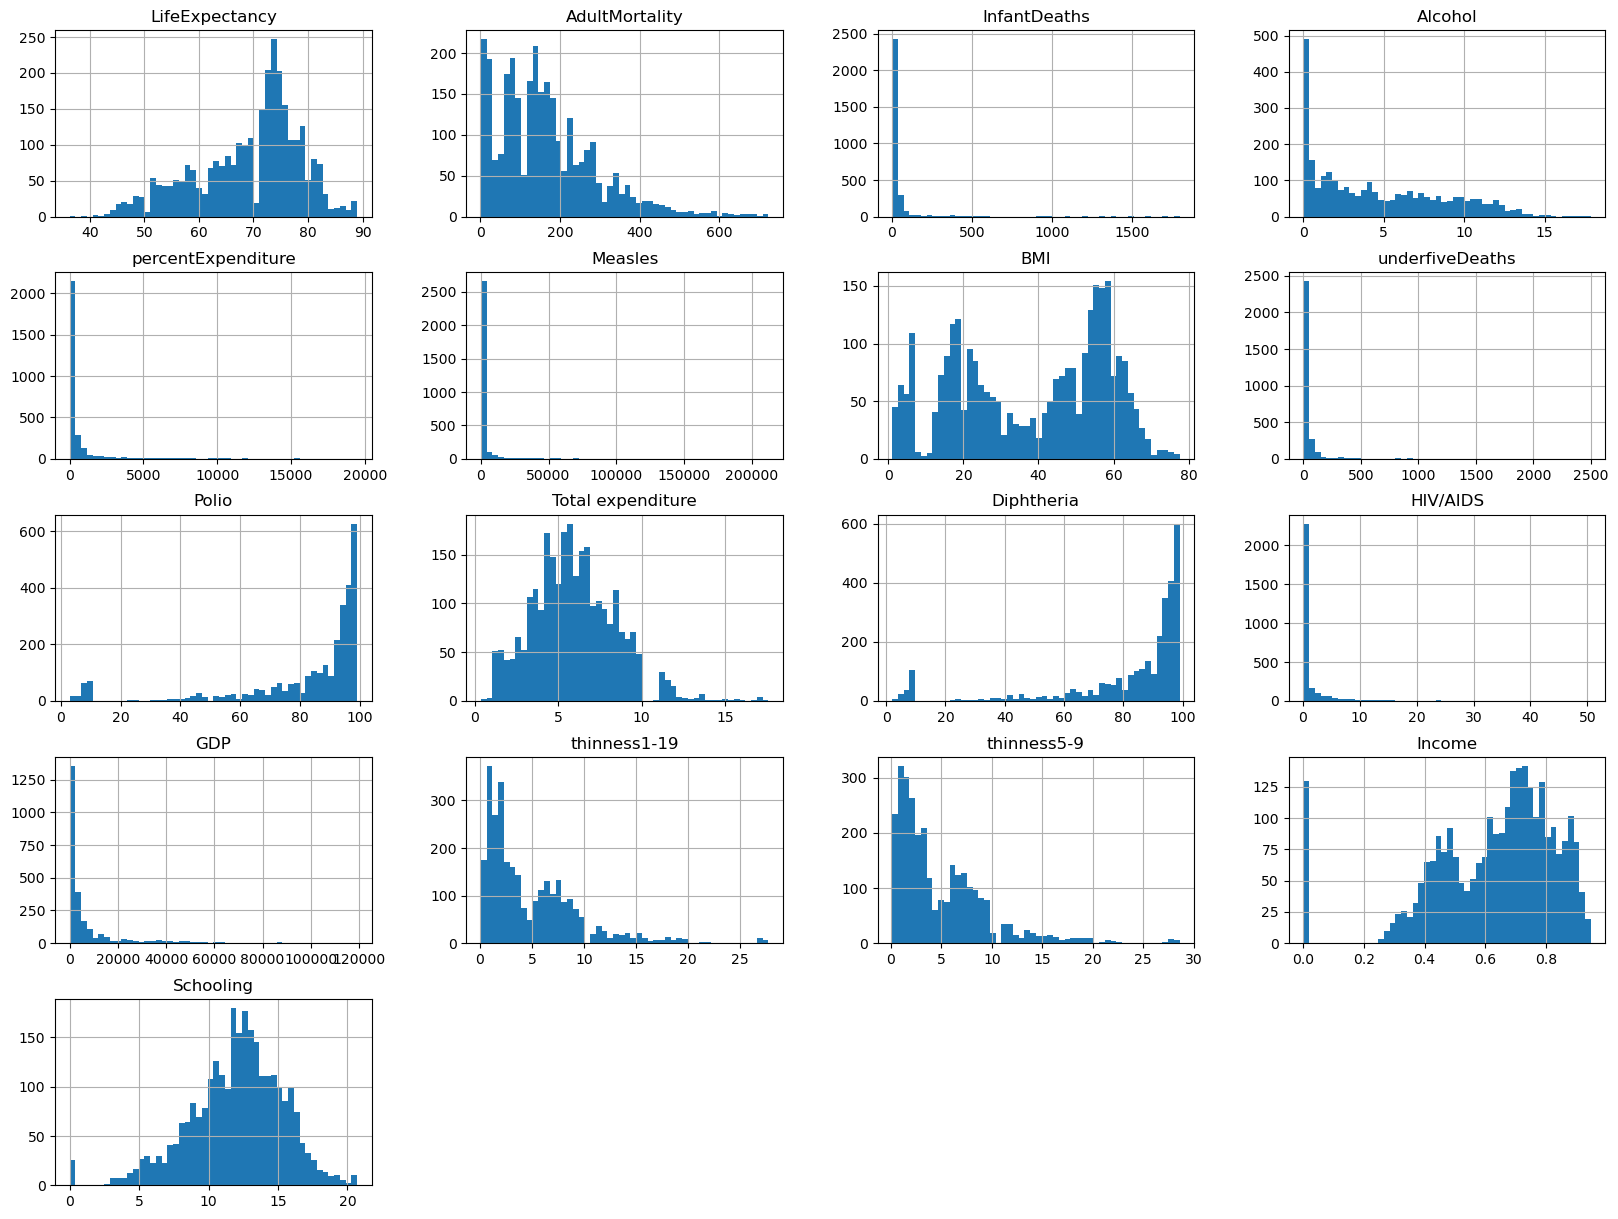

In [31]:
_ = df.hist(bins=50, figsize=(20,15))

'Schooling', 'Income' e 'Total expenditure' tienen una distribución bastante gaussiana, por lo que será razonable rellenar los valores nulos con la mediana.
(aunque hay una franja concreta del histograma que falta en "Total expenditure" muy sospechosa que podría ser interesante de estudiar).

Pero llegados a este punto, separaremos el dataset en train y test, lo que daría la posibilidad de comparar los resultados de los distintos métodos de tratamiento de valores faltantes.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="LifeExpectancy"),
    df["LifeExpectancy"],
    test_size=0.2, random_state=42
    )

In [33]:
from sklearn.impute import SimpleImputer
X_train['Schooling'] = SimpleImputer(strategy="median").fit_transform(X_train[['Schooling']])
X_train['Income'] = SimpleImputer(strategy="median").fit_transform(X_train[['Income']])
X_train['Total expenditure'] = SimpleImputer(strategy="median").fit_transform(X_train[['Total expenditure']])

In [34]:
na_per_colum = X_train.isna().sum()
na_per_colum[na_per_colum > 0].sort_values(ascending=False)

GDP             347
Alcohol         155
BMI              26
thinness5-9      26
thinness1-19     26
Polio            14
Diphtheria       14
dtype: int64

Finalmente, vamos a utilizar `KNNImputer` para rellenar los valores no disponibles que quedan, aunque hay que tener presente que es la cantidad de valores no disponibles 'GDP' y 'Alcohol' es muy alta, por lo que el resultado puede ser muy malo.

Para ello, será necesario escalar antes las columnas.

In [35]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().set_output(transform="pandas").fit_transform(X_train)

In [36]:
from sklearn.impute import KNNImputer
X_train= KNNImputer(n_neighbors=np.sqrt(X_train.shape[0]).astype(int)).set_output(transform="pandas").fit_transform(X_train)

In [37]:
na_per_colum = X_train.isna().sum()
na_per_colum[na_per_colum > 0].sort_values(ascending=False)

Series([], dtype: int64)

Con esto hemos usado los 4 métodos de tratamiento de valores faltantes vistos y ya tenemos un dataset listo para entrenar.

## Entrenamiento y testeo del modelo

In [38]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression().fit(X_train, y_train)

In [39]:
X_test['Schooling'] = SimpleImputer(strategy="median").fit_transform(X_test[['Schooling']])
X_test['Income'] = SimpleImputer(strategy="median").fit_transform(X_test[['Income']])
X_test['Total expenditure'] = SimpleImputer(strategy="median").fit_transform(X_test[['Total expenditure']])
X_test = StandardScaler().set_output(transform="pandas").fit_transform(X_test)
X_test= KNNImputer(n_neighbors=np.sqrt(X_train.shape[0]).astype(int)).set_output(transform="pandas").fit_transform(X_test)


y_test_pred = model_linear.predict(X_test)
from sklearn.metrics import mean_absolute_error
mae_linear = mean_absolute_error(y_test, y_test_pred)
print("MAE Regresión lineal: ", mae_linear)

MAE Regresión lineal:  2.9997507282036047


## Fuentes

https://www.kaggle.com/code/mathchi/life-expectancy-who-with-several-ml-techniques